# Install Dependencies

In [ ]:
import tensorflow as tf

# Tensors

**references**:
  - [Coursera:Custom and Distributed Training with TensorFlow](https://www.coursera.org/learn/custom-distributed-training-with-tensorflow/lecture/qICrM/calculate-gradients-on-higher-order-functions)

**Introduction:**

- Tensors contains `dtype` and `shape`
- scalar, vector, matrix, etc.





## `tf.constant` and `tf.Variable`

- values in `tf.constant` cannot be changed (immutable)
- values in `tf.Variable` can be changed

In [ ]:
# some basic operations

import numpy as np

x = np.array(range(0 ,25))
print("x array: ", x)
x = tf.constant(x)
print("tensors: ", x)

y = tf.constant(2, dtype=tf.float32)
print(y)

x array:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
tensors:  tf.Tensor(
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24], shape=(25,), dtype=int64)
tf.Tensor(2.0, shape=(), dtype=float32)


### `tf.GradientTape()` basics

In [ ]:
# tf.GradientTape() on lower power functions
x = tf.constant(3.0)

with tf.GradientTape() as g:
  g.watch(x)
  y = x * x

dy_dx = g.gradient(y, x)
print(dy_dx)

tf.Tensor(6.0, shape=(), dtype=float32)


In [ ]:
# tf.GradientTape() on higher power functions

x = tf.ones((2, 2))
print(f"x:\n {x}")

with tf.GradientTape() as tape:
  tape.watch(x)

  y = tf.reduce_sum(x) # y = 1+1+1+1 = 4
  z = tf.square(y) # z=4^2=16

# derivative of z wrt to the original input x
dz_dx = tape.gradient(z, x)
# dz_dx = dz_dy*dy_dx = 2y*dy_dx = 8*[1]
print(f"dz_dx:\n {dz_dx}")

x:
 [[1. 1.]
 [1. 1.]]
dz_dx:
 [[8. 8.]
 [8. 8.]]


In [ ]:
# set persistent=True if the gradient needs to be re-used
# for instance

x = tf.constant(3.0)

with tf.GradientTape(persistent=True) as tape:

  tape.watch(x)
  y = x**2 # y = 3**2 = 9
  z = y**2 # z = 9**2 = 81

# here the tape can be called twice
dz_dx = tape.gradient(z, x) # dz_dx = dz_dy*dy_dx = 2*9 * 2*3 = 18*6 = 108
dy_dx = tape.gradient(y, x) # dy_dx = 2*3 = 6

print(
    f"dz_dx:\n {dz_dx}\ndy_dx:\n {dy_dx}"
)

# need to manually drop the reference to the tape
del tape

dz_dx:
 108.0
dy_dx:
 6.0


In [ ]:
x = tf.Variable(3.0) # cannot be tf.constant

with tf.GradientTape() as tape_2:
  with tf.GradientTape() as tape_1:

    y = x * x * x

  dy_dx = tape_1.gradient(y, x) # dy_dx = 3x^2 = 3*3^2 = 27
d2y_dx2 = tape_2.gradient(dy_dx, x) # d2y_dx2 = 6x = 6*3 = 18

print(f"dy_dx:\n{dy_dx}\nd2y_dx2:\n{d2y_dx2}")

dy_dx:
27.0
d2y_dx2:
18.0


# Introduction to graphs and `tf.function`


source: https://www.tensorflow.org/guide/intro_to_graphs

## Objective

- to understand how `execution graphs` work in Tensorflow


## What Are Graphs


Graph execution:

- tensor computations as a tf **graph** , `tf.Graph`

Graphs:

- is a data structures that contains (defined in `tf.Graph`):
  - a set of `tf.Operation` objects (rep. units of computation)
  - a set of `tf.Tensor` objects (rep. units of data tha **flow** between operations)



### eager operation vs. graph operation:

eager operation:

- intuitive (code in python)
- immediate results

graph operation:

- better performance (outside python)
  
  - run fast (faster than eager execution, but takes time to build graphs on the first run)
  - run in parallel
  - run on multiple devices

In [ ]:
import tensorflow as tf

In [ ]:
# tf.function:
# input: a reg python function
# output: Function (builds tf graphs from the python function)

def a_reg_python_func(x, y, b):
  x = tf.matmul(x, y)
  x = x + b

  return x

a_graph_func = tf.function(a_reg_python_func)

In [ ]:
# Make some tensors.
x1 = tf.constant([[1.0, 2.0]])
y1 = tf.constant([[2.0], [3.0]])
b1 = tf.constant(4.0)

In [ ]:
orig_value = a_reg_python_func(x1, y1, b1).numpy()
# Call a `Function` like a Python function.
tf_function_value = a_graph_func(x1, y1, b1).numpy()
assert(orig_value == tf_function_value)

In [ ]:
print(f"original function value: {orig_value}, {type(orig_value)}")
print(f"graph function value: {tf_function_value}, {type(tf_function_value)}")

functions that are written in tensorflow are a mixture of **TF operations** and **python** logic (`if_else` etc).

Converting python code to graph-generating code using `tf.autograph`

In [ ]:
# another example
# converting python function to graphs


# this function is a mixture of
# python logic and tf operations:
def simple_relu(x):
  if tf.greater(x, 0):
    return x
  else:
    return 0

# convert the above python function to
# tensorflow graph using
# tf.function()
tf_simple_relu = tf.function(simple_relu)

# trying out different input formats (same?)
print(tf_simple_relu(-1))
print(tf_simple_relu(tf.constant(-1)))
print(tf_simple_relu(tf.constant(-1).numpy())) # official tf


In [ ]:
# inspect the output
print(tf.autograph.to_code(simple_relu))

In [ ]:
# This is the graph itself.
print(tf_simple_relu.get_concrete_function(tf.constant(1)).graph.as_graph_def())

## Eager Execution in Tensorflow

- evaluate values immediately
- broadcasting support
- operation overloading
- numpy compatibility


In [ ]:
# broadcasting

a = tf.constant([[1, 2],
                 [3, 4]])

print(tf.add(a, 1))

# python operations
print(a ** 2)

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[ 1  4]
 [ 9 16]], shape=(2, 2), dtype=int32)


In [ ]:
# tf variables

v = tf.Variable(0.0)

print("v+1: ", v + 1)

v = tf.Variable(0.0)

print("v.assign_add(): ", v.assign_add(1)) # for graph execution 'UnreadVariable'

print("read_value(): ", v.read_value().numpy())

v+1:  tf.Tensor(1.0, shape=(), dtype=float32)
v.assign_add():  <tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1.0>
read_value():  1.0


In [ ]:
# tf.variable in custom layers

class MyLayer(tf.keras.layers.Layer):

  def __init__(self):
    super(MyLayer, self).__init__()
    self.my_var = tf.Variable(100)
    # self.my_other_var_list = [tf.Variable(x) for x in range(2)]
    self.my_other_var_list = tf.Variable(200)
    self.my_constant = tf.constant(1)

m = MyLayer()
print([variable.numpy() for variable in m.variables]) # only prints out variables

[100, 200]


In [ ]:
# change data types using tf.cast

tensor = tf.constant([1,2,3])

print(tensor)

tensor = tf.cast(tensor, dtype=tf.float32)

print(tensor.dtype)

tf.Tensor([1 2 3], shape=(3,), dtype=int32)
<dtype: 'float32'>


## Graph execution

**Graph execution**:

- parallelism
- distributed execution
- compilation
- portability

In [ ]:
# Function runs graph execution by default

@tf.function
def get_MSE(y_true, y_pred):
  sq_diff = tf.pow(y_true - y_pred, 2)

  return tf.reduce_mean(sq_diff)

print(tf.autograph.to_code(get_MSE.python_function))

y_true = tf.random.uniform([5], maxval=10, dtype=tf.int32)
y_pred = tf.random.uniform([5], maxval=10, dtype=tf.int32)

print(y_true)
print(y_pred)

def tf__get_MSE(y_true, y_pred):
    with ag__.FunctionScope('get_MSE', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        sq_diff = ag__.converted_call(ag__.ld(tf).pow, (ag__.ld(y_true) - ag__.ld(y_pred), 2), None, fscope)
        try:
            do_return = True
            retval_ = ag__.converted_call(ag__.ld(tf).reduce_mean, (ag__.ld(sq_diff),), None, fscope)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

tf.Tensor([1 6 1 6 3], shape=(5,), dtype=int32)
tf.Tensor([1 4 5 4 8], shape=(5,), dtype=int32)


In [ ]:
get_MSE(y_true, y_pred)

<tf.Tensor: shape=(), dtype=int32, numpy=9>

In [ ]:
# run Function as eager execution
tf.config.run_functions_eagerly(True)

In [ ]:
get_MSE(y_true, y_pred)

<tf.Tensor: shape=(), dtype=int32, numpy=9>

In [ ]:
# turn off eager functions
tf.config.run_functions_eagerly(False)

In [ ]:
# Function can behave differently
# in eager exection and graph execution:
#

# graph execution
@tf.function
def get_MSE(y_true, y_pred):
  print("Calculating MSE!")
  sq_diff = tf.pow(y_true - y_pred, 2)
  return tf.reduce_mean(sq_diff)

error = get_MSE(y_true, y_pred)
error = get_MSE(y_true, y_pred)
error = get_MSE(y_true, y_pred)

Calculating MSE!


In [ ]:
# eager execution
def get_MSE(y_true, y_pred):
  print("Calculating MSE!")
  sq_diff = tf.pow(y_true - y_pred, 2)
  return tf.reduce_mean(sq_diff)

error = get_MSE(y_true, y_pred)
error = get_MSE(y_true, y_pred)
error = get_MSE(y_true, y_pred)

Calculating MSE!
Calculating MSE!
Calculating MSE!


In [ ]:
# autograph do not accept conditions

@tf.function
def f(x):
  if x > 0:
    x = x * x
  return x

print(tf.autograph.to_code(f.python_function))

def tf__f(x):
    with ag__.FunctionScope('f', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def if_body():
            nonlocal x
            x = ag__.ld(x) * ag__.ld(x)

        def else_body():
            nonlocal x
            pass
        ag__.if_stmt(ag__.ld(x) > 0, if_body, else_body, get_state, set_state, ('x',), 1)
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



In [ ]:
# tf.function and gradiettape
# add() is an annotated function

@tf.function
def add(a, b):
  return a + b

v = tf.Variable(1.0)

with tf.GradientTape() as tape:
  result = add(v, 1.0)

tape.gradient(result, v).numpy()

1.0

In [ ]:
# chain multiple functions
# a python function inside @tf.function
# can also run in graph mode

def linear_layer(x):
  return 2*x + 1

@tf.function
def deep_net(x):
  return tf.nn.relu(linear_layer(x))

deep_net(tf.constant((1,2,3)))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 5, 7], dtype=int32)>

In [ ]:
# python functions are polymorphic

@tf.function
def double(a):
  return a + a

print(double(tf.constant(1)).numpy())
print(double(tf.constant(1.1)).numpy())
print(double(tf.constant("a")).numpy())

2
2.2
b'aa'


In [ ]:
# tf.function with keras

class CustomModel(tf.keras.models.Model):
  @tf.function
  def call(self, input_data):
    if tf.reduce_mean(input_data) > 0:
      return input_data
    else:
      return input_data//2

In [ ]:
# @tf.function works best when there are a lot of ops
# e.g. "for", "==", "if", "%" etc

@tf.function
def fizzbuzz(max_num):
  counter = 0
  for num in range(max_num):
    if num % 3 == 0 and num % 5 == 0:
      print("fizzbuzz")
    elif num % 3 == 0:
      print("fizz")
    elif num % 5 == 0:
      print("buzz")
    else:
      print(num)
    counter += 1
  return counter

print(tf.autograph.to_code(fizzbuzz.python_function))

def tf__fizzbuzz(max_num):
    with ag__.FunctionScope('fizzbuzz', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        counter = 0

        def get_state_3():
            return (counter,)

        def set_state_3(vars_):
            nonlocal counter
            (counter,) = vars_

        def loop_body(itr):
            nonlocal counter
            num = itr

            def get_state_2():
                return ()

            def set_state_2(block_vars):
                pass

            def if_body_2():
                ag__.ld(print)('fizzbuzz')

            def else_body_2():

                def get_state_1():
                    return ()

                def set_state_1(block_vars):
                    pass

                def if_body_1():
                    ag__.ld(print)('fizz')

                def else_body_1(

### Control Dependencies

In [ ]:
# automatic control dependencies
# ensure the right sequence
a = tf.Variable(1.0)
b = tf.Variable(2.0)

@tf.function
def f(x, y):
  a.assign(y * b) # a = y * b = 2 * 2 = 4
  b.assign_add(x * a) # b = 2.0 + 1 * 4 = 6
  return a + b

f(1.0, 2.0)

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

In [ ]:
# conditional flows

@tf.function
def sign(x):
  if x > 0:
    return "positive"
  else:
    return "negative"

print(tf.autograph.to_code(sign.python_function))

def tf__sign(x):
    with ag__.FunctionScope('sign', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (do_return, retval_)

        def set_state(vars_):
            nonlocal do_return, retval_
            (do_return, retval_) = vars_

        def if_body():
            nonlocal do_return, retval_
            try:
                do_return = True
                retval_ = 'positive'
            except:
                do_return = False
                raise

        def else_body():
            nonlocal do_return, retval_
            try:
                do_return = True
                retval_ = 'negative'
            except:
                do_return = False
                raise
        ag__.if_stmt(ag__.ld(x) > 0, if_body, else_body, get_state, set_state, ('do_return', 'retval_'),

In [ ]:
# control flows (loops)

@tf.function
def f(x):
  while tf.reduce_sum(x) > 1:
    tf.print(x)
    x = tf.tanh(x)
  return x

print(tf.autograph.to_code(f.python_function))

def tf__f(x):
    with ag__.FunctionScope('f', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def loop_body():
            nonlocal x
            ag__.converted_call(ag__.ld(tf).print, (ag__.ld(x),), None, fscope)
            x = ag__.converted_call(ag__.ld(tf).tanh, (ag__.ld(x),), None, fscope)

        def loop_test():
            return ag__.converted_call(ag__.ld(tf).reduce_sum, (ag__.ld(x),), None, fscope) > 1
        ag__.while_stmt(loop_test, loop_body, get_state, set_state, ('x',), {})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



In [ ]:
# default behavior of tracing variables (eager mode)
# print() and tf.print() behave differently when
# decorated by @tf.function
# python print() not designed for graph execution
# hence only executed once

def f(x):
  print("traced with ", x)

for i in range(5):
  f(2)

print("tf.function: ")

@tf.function
def f(x):
  print("traced with ", x)
  tf.print("executed with ", x)

for i in range(5):
  f(2)

traced with  2
traced with  2
traced with  2
traced with  2
traced with  2
tf.function: 
traced with  2
executed with  2
executed with  2
executed with  2
executed with  2
executed with  2


In [ ]:
# dangerous variable creation behavior

@tf.function
def f(x):
  v = tf.Variable(1.0) # do not create variable here
  v.assign_add(x)
  return v

f(1)

ValueError: ignored

# Gradient wrt a model

# Model Training：Custom Training Loop steps

**references**:
- [tensorflow documentation](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit?fireglass_rsn=true)
- [Coursera:Custom and Distributed Training with TensorFlow](https://www.coursera.org/learn/custom-distributed-training-with-tensorflow/lecture/qICrM/calculate-gradients-on-higher-order-functions)


**basics:**

- train using `model.compile()` and `model.fit()`
- specify **optimizer**, **loss** etc in `model.compile()`
- `model.fit()` loops through batches of training data to:
  - update trainable weights to minimize loss
  - achieves the above using chosen optimizer

**steps for training network:**
- define the network
- prepare the training data
- define loss and optimizer
- train the model on training inputs by minimizing loss using custom optimizer
- validate the model


In [ ]:
w = tf.Variable([[1.0]])

with tf.GradientTape() as tape:

  loss = w ** 2

dw_dx = tape.gradient(loss, w)

print(dw_dx)

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


In [ ]:
# gradient descent with tf.gradienttape

# exmaple
def train_step(images, labels):

  with tf.GradientTape() as tape:

    # invoke the forward pass
    # logits: raw model prediction for each category for
    #         a multi-class classification
    # usually logits are fed into a softmax function to
    # turn them into probabilities for each category
    logits = model(images, trainig=True)

    # loss obtained for each forward pass
    # to update the model in order to reduce the
    # model's prediction errors
    loss_value = loss_object(labels, logits)

  # appending the average loss
  loss_history.append(loss_value.numpy().mean())

  # compute the gradients wrt to model variables
  # passing the loss_value and all model trainable variables
  grads = tape.gradient(loss_value, model.trainable_variables)

  # apply gradient on an optimizer
  optimizer.apply_gradient(zip(grads, model.trainable_variables))


In [ ]:
layer = tf.keras.layers.Dense(2, activation="relu")
x = tf.constant([[1., 2., 3.]])
loss_history = []
with tf.GradientTape() as tape:
  # forward pass
  y = layer(x)
  # calculate the loss
  loss = tf.reduce_mean(y**2)

# appending losses
loss_history.append(loss)
print("loss history: ", loss_history, "\n")

# calculate gradients
grad = tape.gradient(loss, layer.trainable_variables)
print(grad)

for var, g in zip(layer.trainable_variables, grad):
  print(f'{var.name}, shape: {g.shape}, {g}')

loss history:  [<tf.Tensor: shape=(), dtype=float32, numpy=2.4353147>] 

[<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.       , 2.2069502],
       [0.       , 4.4139004],
       [0.       , 6.6208506]], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.       , 2.2069502], dtype=float32)>]
dense_4/kernel:0, shape: (3, 2), [[0.        2.2069502]
 [0.        4.4139004]
 [0.        6.6208506]]
dense_4/bias:0, shape: (2,), [0.        2.2069502]


In [ ]:
x0 = tf.Variable(3.0, name="x0")
x1 = tf.Variable(3.0, name="x1", trainable=False) # not trainable
x2 = tf.Variable(3.0, name="x2") + 1.0 # not trainable
x3 = tf.constant(3.0, name="x2") # not trainable cuz not a variable

with tf.GradientTape() as tape:
  y = (x0**2) + (x1**2) + (x2**2)

grad = tape.gradient(y, [x0, x1, x2, x3])

for g in grad:
  print(g)

tf.Tensor(6.0, shape=(), dtype=float32)
None
None
None


In [ ]:
[var.name for var in tape.watched_variables()]

['x0:0']

In [ ]:
x = tf.constant(3.0)
with tf.GradientTape() as tape:
  tape.watch(x)
  y = x**2
# dy = 2x * dx
dy_dx = tape.gradient(y, x)
print(dy_dx.numpy())

6.0


In [ ]:
x = tf.Variable(3.0)
with tf.GradientTape() as tape:
  # tape.watch(x)
  y = x**2
# dy = 2x * dx
dy_dx = tape.gradient(y, x)
print(dy_dx.numpy())

6.0


### Intermediate results

In [ ]:
x = tf.constant(3.0)
with tf.GradientTape() as tape:
  tape.watch(x)
  y = x * x
  z = y * y
# Use the tape to compute the gradient of z with respect to the
# intermediate value y.
# dz_dy = 2 * y and y = x ** 2 = 9
print(tape.gradient(z, y).numpy())
print(tape.gradient(z, y).numpy())


18.0


RuntimeError: ignored

In [ ]:
x = tf.constant([1.0, 3.0])
with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  y = x * x
  z = y * y
# Use the tape to compute the gradient of z with respect to the
# intermediate value y.
# dz_dy = 2 * y and y = x ** 2 = 9
print(tape.gradient(z, x).numpy())
print(tape.gradient(y, x).numpy())
print(tape.gradient(z, x).numpy())
print(tape.gradient(y, x).numpy())


[  4. 108.]
[2. 6.]
[  4. 108.]
[2. 6.]


In [ ]:
x = tf.linspace(-10.0, 10.0, 200+1)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = tf.nn.sigmoid(x)

dy_dx = tape.gradient(y, x)

In [ ]:
# print(x, y, dy_dx)

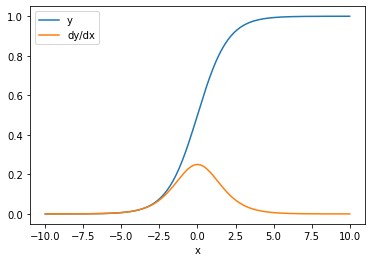

In [ ]:
import matplotlib.pyplot as plt

plt.plot(x, y, label="y")
plt.plot(x, dy_dx, label="dy/dx")
plt.legend()
_ = plt.xlabel("x")

In [ ]:
x = tf.constant(1.0)
v0 = tf.Variable(2.0)
v1 = tf.Variable(2.0)

with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  if x > 0.0:
    result = v0
  else:
    result = v1**2

dv0, dv1 = tape.gradient(result, [v0, v1])
# the tape either records result = v0 or result = v1**2.
# The gradient with respect to x is always None.
print(dv0, dv1)

tf.Tensor(1.0, shape=(), dtype=float32) None



## Gradient Tape

In [ ]:
# higher order derivatives

x = tf.constant(5.0)

with tf.GradientTape() as g:
  g.watch(x)
  with tf.GradientTape() as gg:
    gg.watch(x)
    y = x * x
  dy_dx = gg.gradient(y, x)
d2y_dx2 = g.gradient(dy_dx, x)

print(dy_dx)
print(d2y_dx2)

tf.Tensor(10.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)


In [ ]:
# tf variable and constants

x = tf.Variable(3.0)
x2 = tf.Variable(3.0)

# persistent=True to compute multiple gradients
# over the same computation

with tf.GradientTape(persistent=True) as g:
    y = x * x
    y2 = y * x2
dy_dx = g.gradient(y, x)       # 6
dy2_dx2 = g.gradient(y2, x2)   # 9
del g  # Drop the reference to the tape
print(dy_dx)
print(dy2_dx2)

tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)


In [ ]:
# by default all trainable variables are watched
# set watch_accessed_variables=False to

x = tf.Variable(2.0)
w = tf.Variable(5.0)

with tf.GradientTape(
    watch_accessed_variables=False,
    persistent=True
) as tape:
  tape.watch(x)
  y = x ** 2
  z = w ** 3
dy_dx = tape.gradient(y, x)
dw_dx = tape.gradient(w, x)
print(dy_dx)
print(dw_dx) # output None cuz

tf.Tensor(4.0, shape=(), dtype=float32)
None


In [ ]:
# a simple machine leaning example

import numpy as np
import random

# gradient tape

def fit_data(real_x, real_y):

  with tf.GradientTape(persistent=True) as tape:

    # usually two things to do inside gradient tape
    # (i) make predicrtion
    pred_y = w * real_x + b

    # (ii) calculate loss
    reg_loss = simple_loss(real_y, pred_y)

  # calculate gradients
  w_gradient = tape.gradient(reg_loss, w)
  b_gradient = tape.gradient(reg_loss, b)

  # update variables
  w.assign_sub(w_gradient, LEARNING_RATE)
  b.assign_sub(b_gradient, LEARNING_RATE)

# training data
x_train = np.array([-1.0, 0.0, 1.0, 2.0, 3.0, 4.0], dtype=float)
y_train = np.array([-3.0, -1.0, 1.0, 3.0, 5.0, 7.0], dtype=float)

# trainable variables
w = tf.Variable(random.random(), trainable=True) # set as True so gradienttape will track them
b = tf.Variable(random.random(), trainable=True)

# loss function
def simple_loss(real_y, pred_y):
  return tf.abs(real_y - pred_y)

# learning rate
LEARNING_RATE = 0.001

# training
for _ in range(500):
  fit_data(x_train, y_train)

print(f"y = {w.numpy()}x + {b.numpy()}")

y ~= 0.3180198669433594x + -1.7427592277526855


In [ ]:
a = tf.keras.layers.Dense(32)
a.variables

[]

In [ ]:
a = tf.keras.layers.Dense(32)
b = tf.keras.layers.Dense(32)

with tf.GradientTape(
    watch_accessed_variables=False # watch any trainable variables
) as tape:
  tape.watch(a.variables)
  result = b(a(inputs))
tape.gradient(result, a.variables)

NameError: ignored

In [ ]:
# batch jacobian

with tf.GradientTape() as g:
  x = tf.constant([[1., 2.], [3., 4.]], dtype=tf.float32)
  g.watch(x)
  y = x*x

batch_jacobian = g.batch_jacobian(y, x)

print(batch_jacobian)

In [ ]:
# jacobian

with tf.GradientTape() as g:
  x = tf.constant([1, 2], dtype=tf.float32)
  g.watch(x)
  y = x*x

jacobian = g.jacobian(y, x)

print(jacobian)

In [ ]:
# reset

with tf.GradientTape() as tape:
  loss = loss_fn()
with tf.GradientTape() as tape:
  loss += other_loss_fn()
t.gradient(loss, ..)

SyntaxError: ignored

In [ ]:
# GradientTape() on tensors

w = tf.Variable(tf.random.normal((3, 2)), name="w")
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name="b")
x = [[1., 2., 3.]]

with tf.GradientTape(persistent=True) as tape:
  y = x @ w  + b
  loss = tf.reduce_mean(y**2)

[dl_dw, dl_db] = tape.gradient(loss, [w, b])

In [ ]:
dl_dw, dl_db

(<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[ -4.7988124,  -0.5380175],
        [ -9.597625 ,  -1.076035 ],
        [-14.396437 ,  -1.6140525]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-4.7988124, -0.5380175], dtype=float32)>)

## A simple regression model

Epoch: 0: w=5.00, b=0.00, loss=26.43782
Epoch: 1: w=3.94, b=0.02, loss=16.43521
Epoch: 2: w=3.11, b=0.03, loss=10.21774
Epoch: 3: w=2.45, b=0.03, loss=6.35280
Epoch: 4: w=1.93, b=0.03, loss=3.95010
Epoch: 5: w=1.52, b=0.03, loss=2.45631
Epoch: 6: w=1.20, b=0.03, loss=1.52754
Epoch: 7: w=0.95, b=0.03, loss=0.95003
Epoch: 8: w=0.75, b=0.03, loss=0.59090
Epoch: 9: w=0.59, b=0.02, loss=0.36756
Epoch: 10: w=0.46, b=0.02, loss=0.22866
Epoch: 11: w=0.37, b=0.02, loss=0.14226
Epoch: 12: w=0.29, b=0.02, loss=0.08851
Epoch: 13: w=0.23, b=0.01, loss=0.05508
Epoch: 14: w=0.18, b=0.01, loss=0.03428
Epoch: 15: w=0.14, b=0.01, loss=0.02133
Epoch: 16: w=0.11, b=0.01, loss=0.01328
Epoch: 17: w=0.09, b=0.01, loss=0.00827
Epoch: 18: w=0.07, b=0.01, loss=0.00515
Epoch: 19: w=0.05, b=0.01, loss=0.00320


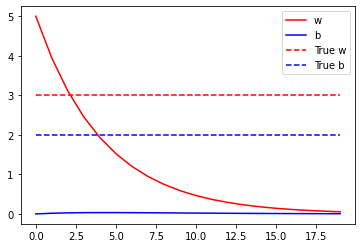

In [ ]:
# import dependencies
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# some customized functions

def plot_data(iputs, outputs, predicted_outputs):
  real = plt.scatter(inputs, outputs, c="b")
  predicted = plt.scatter(inputs, predicted_outputs, c="r")
  plt.legend((real, predicted), ("real data", "predicted data"))
  plt.show()


# 1. define the model from scratch

class Model():
  def __init__(self):
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x):
    return self.w * x + self.b

# 2. prepare the training data

TRUE_w = 3.0
TRUE_b = 2.0

NUM_EXAMPLES = 1000

random_xs = tf.random.normal(shape=[NUM_EXAMPLES])

ys = (TRUE_w * random_xs) + TRUE_b

# 3. mean squared error loss

def loss(y_true, y_pred):
  return tf.reduce_mean(tf.square(y_true, y_pred))

# 4. train the model

# Training loop:
# --------------
# 1. initialize model
# 2. for each epoch:
#    2.1 calculate loss for each input
#    2.2 calculate gradient of loss using GradientTape
#    2.3 update model Trainable weights using gradient
#        and learning rate

# calculate partial derivative of loss
def train(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as tape:
    current_loss = loss(model(inputs), outputs)

  # caculate the gradient (which is the derivative of w and b)
  # dL_dw and dL_db
  dw, db = tape.gradient(current_loss, [model.w, model.b])

  # update the model variables
  model.w.assign_sub(learning_rate * dw) # w = w - learning_rate * dL_dw
  model.b.assign_sub(learning_rate * db) # b = b - learning_rate * dL_db

  return current_loss

# define the training loops
model = Model()

list_w, list_b = [], []
losses = []

epochs = range(20)

for epoch in epochs:
  list_w.append(model.w.numpy())
  list_b.append(model.b.numpy())
  current_loss = train(model, random_xs, ys, learning_rate=0.1)
  losses.append(current_loss)
  print(f"Epoch: {epoch}: w={list_w[-1]:1.2f}, b={list_b[-1]:1.2f}, loss={current_loss:2.5f}")

# 5. validate the model

plt.plot(epochs, list_w, "r",
         epochs, list_b, "b")

plt.plot([TRUE_w] * len(epochs), "r--",
         [TRUE_b] * len(epochs), "b--")
plt.legend(["w", "b", "True w", "True b"])
plt.show()

## A simple neural network

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

### 1. Define the network

In [ ]:
def base_model():
  inputs = tf.keras.Input(shape=(784, ), name="clothing")
  x = tf.keras.layers.Dense(64, activation="relu", name="dense_1")(inputs)
  x = tf.keras.layers.Dense(64, activation="relu", name="dense_2")(x)
  output = tf.keras.layers.Dense(10, activation="softmax", name="predictions")(x)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

### 2. Prepare Training Data Pipeline

In [ ]:
train_data = tfds.load("fashion_mnist", split="train")
test_data = tfds.load("fashion_mnist", split="test")

def format_image(data):
  image = data["image"]
  image = tf.reshape(image, [-1])
  image = tf.cast(image, "float32")
  image = image/255.0
  return image, data["label"]

train_data = train_data.map(format_image)
test_data = test_data.map(format_image)

batch_size = 64
train = train_data.shuffle(buffer_size=1024).batch(batch_size)
test = test_data.batch(batch_size=batch_size)

### 3. Define Loss and Optimizer

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

### 4. Define the Metrics

Low level handling of `keras` metrics

* call `metric.update_state()` to accumulate metric statistics after each batch
* call `metric.result` to get current value of metric for display
* call `metric.reset_state()` to reset metric value typically at end of epoch

In [ ]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

### 5. Define the Training Loop

* for each epoch, loop through the training batches and calculate gradients
* these gradients are used according to the optimization algorithm chosen, to update the trainable weights of the model
* loop through validation batches and calculate validation loss

In [ ]:
# calculate and apply gradients
def apply_gradient(optimizer, model, x, y):
  with tf.GradientTape() as tape:
    logits = model(x)
    loss_value = loss_object(y_true=y, y_pred=logits)

  # differentiating the trainable weights against loss to calculate
  # the gradients
  gradients = tape.gradient(loss_value, model.trainable_weights)

  # using the optimizer to update the trainable weights
  # is zip only for batches?
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))

  return logits, loss_value


def train_data_for_one_epoch():
  losses = []
  pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True,
              bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}")
  for step, (x_batch_train, y_batch_train) in enumerate(train):

    logits, loss_value = apply_gradient(optimizer, model, x_batch_train, y_batch_train)

    losses.append(loss_value)
    # calcualting the accuracy by passing the groudtruth and prediction logits
    train_acc_metric(y_batch_train, logits)
    pbar.set_description("training loss for step %s: $.4f" % (int(step), float(loss_value))
    pbar.update()

  return losses


# calculate validation loss
def perform_validation():
  losses = []
  # iterate through the validation batches
  for x_val, y_val in test:

    val_logits = model(x_val)
    val_loss = loss_object(y_true=y_val, y_pred=val_logits)
    losses.append(val_loss)
    val_acc_metric(y_val, val_logits)

  return losses

### Training the Model

In [ ]:
model = base_model()

epochs = 10

for epoch in range(epochs):

  # run through training batches
  losses_train = train_data_for_one_epoch()
  train_acc = train_acc_metric.result()

  # calculate validation loss and metrics
  losses_val = perform_validation()
  val_acc = val_acc_metric.result()

  losses_train_mean = np.mean(losses_train)
  loss_val_mean = np.mean(losses_val)

  epochs_val_loss.append(losses_val_mean)
  epochs_train_losses.append(losses_train_mean)

  print()

  train_acc_metric.reset_states()
  val_acc_metric.reset_states()

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
class CustomModel(keras.Model):

  def train_step(self, data):
    x, y = data

    with tf.GradientTape() as tape:
      y_pred = self(x, training=True) # forward pass
      loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

    # compute gradients
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    # update weights
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))

    # update metrics
    self.compiled_metrics.update_state(y, y_pred)
    # return a dict mapping metric names to current value
    return {m.name: m.result() for m in self.metrics}

In [ ]:
import numpy as np
# Construct and compile an instance of CustomModel
inputs = keras.Input(shape=(32,))
outputs = keras.layers.Dense(1)(inputs)
model = CustomModel(inputs, outputs)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
# Just use `fit` as usual
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))
model.fit(x, y, epochs=3)

Epoch 1/3
32/32 [==============================] - 1s 2ms/step - loss: 0.4958 - mae: 0.5884
Epoch 2/3
32/32 [==============================] - 0s 2ms/step - loss: 0.2260 - mae: 0.3855
Epoch 3/3
32/32 [==============================] - 0s 2ms/step - loss: 0.1989 - mae: 0.3613


## Going Lower-level

In [ ]:
loss_tracker = keras.metrics.Mean(name="loss")
mae_metric = keras.metrics.MeanAbsoluteError(name="mae")

class CustomModel(keras.Model):
  def train_step(self, data):
    # unpack data, depends on model structure
    x, y = data

    with tf.GradientTape() as tape:
      y_pred = self(x, training=True) # forward pass
      # our own loss
      loss = keras.losses.mean_squared_error(y, y_pred)

    # compute gradients
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)

    # update weights
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))

    # compute own metrics
    loss_tracker.update_state(loss)
    mae_metric.update_state(y, y_pred)
    return {"loss": loss_tracker.result(), "mae": mae_metric.result()}

    @property
    def metrics(self):
      return [loss_tracker, mae_metric]

In [ ]:
inputs = keras.Input(shape=(32, ))
outputs = keras.layers.Dense(1)(inputs)
model = CustomModel(inputs, outputs)

# dont pass a loss or metrics here
model.compile(optimizer="adam")

# Just use `fit` as usual -- you can use callbacks, etc.
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))
model.fit(x, y, epochs=5)

Epoch 1/5
32/32 [==============================] - 0s 1ms/step - loss: 0.3170 - mae: 0.4534
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 0.2606 - mae: 0.4136
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 0.2460 - mae: 0.4011
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 0.2387 - mae: 0.3948
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 0.2319 - mae: 0.3895


### Sample weights and class weights

In [ ]:
class CustomModel(keras.Model):

  def train_step(self, data):
    if len(data) == 3:
      x, y, sample_weight = data
    else:
      sample_weight = None
      x, y = data

    with tf.GradientTape() as tape:
      y_pred = self(x, training=True)
      loss = self.compiled_loss(
          y,
          y_pred,
          sample_weight=sample_weight,
          regularization_losses=self.losses,
      )

      # compute gradient
      trainable_vars = self.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)

      # update weights
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))

      # update metrics - Metrics are compiled in
      self.compiled_metrics.update_state(y, y_pred, sample_weight=sample_weight)

      # return a dict to map
      return {m.name: m.result() for m in self.metrics}

In [ ]:
inputs = keras.Input(shape=(32,))
outputs = keras.layers.Dense(1)(inputs)

model = CustomModel(inputs, outputs)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# You can now use sample_weight argument
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))
sw = np.random.random((1000, 1))
model.fit(x, y, sample_weight=sw, epochs=3)

Epoch 1/3
32/32 [==============================] - 0s 3ms/step - loss: 0.1323 - mae: 0.4159
Epoch 2/3
32/32 [==============================] - 0s 3ms/step - loss: 0.0968 - mae: 0.3506
Epoch 3/3
32/32 [==============================] - 0s 2ms/step - loss: 0.0937 - mae: 0.3458


### Providing your own evaluation step

In [ ]:
class CustomModel(keras.Model):
  def train_step(self, data):
    # unpack data
    if len(data) == 3:
      x, y, sample_weight = data
    else:
      x, y = data

    with tf.GradientTape() as tape:
      y_pred = self(x, training=False) # evaluation
      # update the metrics tracking the loss
      self.compiled_loss(y, y_pred, regularization_losses=self.losses)
      # update the metrics
      self.compiled_metrics.update_state(y, y_pred)

      return {m.name: m.result() for m in self.metrics}

In [ ]:
inputs = keras.Input(shape=(32,))
outputs = keras.layers.Dense(1)(inputs)

model = CustomModel(inputs, outputs)
model.compile(loss="mse", metrics=["mae"])

# Evaluate with our custom test_step
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))
model.evaluate(x, y)

32/32 [==============================] - 0s 1ms/step - loss: 0.6142 - mae: 0.6506


[0.6141979098320007, 0.6505839228630066]

# TF Custom training: walkthrough

https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough?fireglass_rsn=true

In [ ]:
!pip install -q tfds-nightly

     |████████████████████████████████| 4.9 MB 24.9 MB/s 


In [ ]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
print("TensorFlow version: {}".format(tf.__version__))
print("TensorFlow Datasets version: ",tfds.__version__)

TensorFlow version: 2.9.2
TensorFlow Datasets version:  4.7.0+nightly


In [ ]:
ds_preview, info = tfds.load('penguins/simple', split='train', with_info=True)
df = tfds.as_dataframe(ds_preview.take(5), info)
print(df)
print(info.features)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/344 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/penguins/simple/1.0.0.incompleteVF0IH6/penguins-train.tfrecord*...:   0%| …

Dataset penguins downloaded and prepared to /root/tensorflow_datasets/penguins/simple/1.0.0. Subsequent calls will reuse this data.
   body_mass_g  culmen_depth_mm  culmen_length_mm  flipper_length_mm  island  \
0       4200.0             13.9         45.500000              210.0       0   
1       4650.0             13.7         40.900002              214.0       0   
2       5300.0             14.2         51.299999              218.0       0   
3       5650.0             15.0         47.799999              215.0       0   
4       5050.0             15.8         46.299999              215.0       0   

   sex  species  
0    0        2  
1    0        2  
2    1        2  
3    1        2  
4    1        2  
FeaturesDict({
    'body_mass_g': tf.float32,
    'culmen_depth_mm': tf.float32,
    'culmen_length_mm': tf.float32,
    'flipper_length_mm': tf.float32,
    'island': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    'sex': ClassLabel(shape=(), dtype=tf.int64, num_classe

In [ ]:
class_names = ['Adélie', 'Chinstrap', 'Gentoo']

In [ ]:
ds_split, info = tfds.load("penguins/processed", split=['train[:20%]', 'train[20%:]'], as_supervised=True, with_info=True)
ds_test = ds_split[0]
ds_train = ds_split[1]
assert isinstance(ds_test, tf.data.Dataset)
print(info.features)
df_test = tfds.as_dataframe(ds_test.take(5), info)
print("Test dataset sample: ")
print(df_test)
df_train = tfds.as_dataframe(ds_train.take(5), info)
print("Train dataset sample: ")
print(df_train)
ds_train_batch = ds_train.batch(32)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/334 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/penguins/processed/1.0.0.incompleteWPUX8S/penguins-train.tfrecord*...:   0…

Dataset penguins downloaded and prepared to /root/tensorflow_datasets/penguins/processed/1.0.0. Subsequent calls will reuse this data.
FeaturesDict({
    'features': Tensor(shape=(4,), dtype=tf.float32),
    'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
})
Test dataset sample: 
                                         features  species
0  [0.6545454, 0.22619048, 0.89830506, 0.6388889]        2
1        [0.36, 0.04761905, 0.6440678, 0.4027778]        2
2       [0.68, 0.30952382, 0.91525424, 0.6944444]        2
3   [0.6181818, 0.20238096, 0.8135593, 0.6805556]        2
4  [0.5527273, 0.26190478, 0.84745765, 0.7083333]        2
Train dataset sample: 
                                         features  species
0  [0.49818182, 0.6904762, 0.42372882, 0.4027778]        0
1      [0.48, 0.071428575, 0.6440678, 0.44444445]        2
2    [0.7236364, 0.9047619, 0.6440678, 0.5833333]        1
3  [0.34545454, 0.5833333, 0.33898306, 0.3472222]        0
4       [0.10909091, 0.75, 0.35

In [ ]:
features, labels = next(iter(ds_train_batch))
print(features)
print(labels)

tf.Tensor(
[[0.49818182 0.6904762  0.42372882 0.4027778 ]
 [0.48       0.07142857 0.6440678  0.44444445]
 [0.7236364  0.9047619  0.6440678  0.5833333 ]
 [0.34545454 0.5833333  0.33898306 0.3472222 ]
 [0.10909091 0.75       0.3559322  0.41666666]
 [0.6690909  0.63095236 0.47457626 0.19444445]
 [0.8036364  0.9166667  0.4915254  0.44444445]
 [0.4909091  0.75       0.37288135 0.22916667]
 [0.33454546 0.85714287 0.37288135 0.2361111 ]
 [0.32       0.41666666 0.2542373  0.1388889 ]
 [0.41454545 0.5952381  0.5084746  0.19444445]
 [0.14909092 0.48809522 0.2542373  0.125     ]
 [0.23636363 0.4642857  0.27118644 0.05555556]
 [0.22181818 0.5952381  0.22033899 0.3472222 ]
 [0.24727273 0.5595238  0.15254237 0.25694445]
 [0.63272727 0.35714287 0.88135594 0.8194444 ]
 [0.47272727 0.15476191 0.6440678  0.4722222 ]
 [0.6036364  0.23809524 0.84745765 0.7361111 ]
 [0.26909092 0.5595238  0.27118644 0.16666667]
 [0.28       0.71428573 0.20338982 0.5416667 ]
 [0.10545454 0.5714286  0.33898306 0.2847222 ]
 [

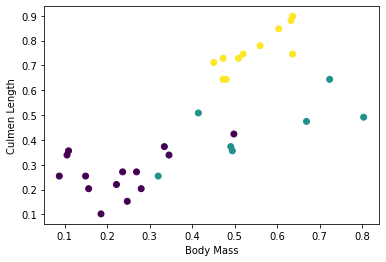

In [ ]:
plt.scatter(features[:,0],
            features[:,2],
            c=labels,
            cmap='viridis')
plt.xlabel("Body Mass")
plt.ylabel("Culmen Length")
plt.show()

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(3) # output logits without tf.nn.softmax
])

In [ ]:
predictions = model(features)

predictions

<tf.Tensor: shape=(32, 3), dtype=float32, numpy=
array([[0.3686532 , 0.2975274 , 0.33381936],
       [0.33427805, 0.3406611 , 0.3250608 ],
       [0.3743221 , 0.29045224, 0.33522552],
       [0.3634907 , 0.30059788, 0.33591133],
       [0.37421092, 0.28721485, 0.3385743 ],
       [0.37830424, 0.29883406, 0.3228616 ],
       [0.38657096, 0.2882731 , 0.32515588],
       [0.38434836, 0.28643364, 0.329218  ],
       [0.39234063, 0.28039223, 0.32726714],
       [0.36083224, 0.30837306, 0.3307946 ],
       [0.37915206, 0.28891405, 0.33193377],
       [0.36662558, 0.30291933, 0.33045518],
       [0.37111127, 0.3009777 , 0.327911  ],
       [0.36793244, 0.2942757 , 0.3377919 ],
       [0.37071842, 0.29612112, 0.33316043],
       [0.33359712, 0.32659906, 0.33980373],
       [0.33575413, 0.3309388 , 0.33330697],
       [0.3332747 , 0.33683538, 0.32988983],
       [0.37100068, 0.29716304, 0.33183628],
       [0.36932346, 0.28687045, 0.34380612],
       [0.3646607 , 0.29785532, 0.337484  ],
      

In [ ]:
print(f"prediction: {tf.math.argmax(predictions, axis=1)}")
print(f"labels: {labels}")

prediction: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 0 0 0 0 1 0 0 2 0 2 1 0 2 0]
labels: [0 2 1 0 0 1 1 1 0 1 1 0 0 0 0 2 2 2 0 0 0 0 2 2 1 2 0 2 2 2 2 0]


In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
def loss(model, x, y, training):
  # training is only needed for training, not for evaluation
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)

In [ ]:
l = loss(model, features, labels, training=False)
print(f"loss test: {l}")

loss test: 1.0906373262405396


In [ ]:
# use GradientTape() to calculate the gradients

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:

    loss_value = loss(model, features, labels, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [ ]:
# create an optimizer

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [ ]:
loss_value, grads = grad(model, features, labels)
print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))
optimizer.apply_gradients(zip(grads, model.trainable_variables))
print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels, training=True).numpy()))

Step: 0, Initial Loss: 1.0906373262405396
Step: 1,         Loss: 1.0903548002243042


In [ ]:
# training loop

train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # training loop
  for x, y in ds_train_batch:
    # optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # track progress
    epoch_loss_avg.update_state(loss_value)
    epoch_accuracy.update_state(y, model(x, training=True))

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print(f"epoch: {epoch: 3d}, loss: {epoch_loss_avg.result()}, accuracy: {epoch_accuracy.result()}")

epoch:   0, loss: 1.0870413780212402, accuracy: 0.5355805158615112
epoch:  50, loss: 0.9948222637176514, accuracy: 0.8052434325218201
epoch:  100, loss: 0.8730146288871765, accuracy: 0.8052434325218201
epoch:  150, loss: 0.8045201897621155, accuracy: 0.8052434325218201
epoch:  200, loss: 0.7841302156448364, accuracy: 0.8052434325218201


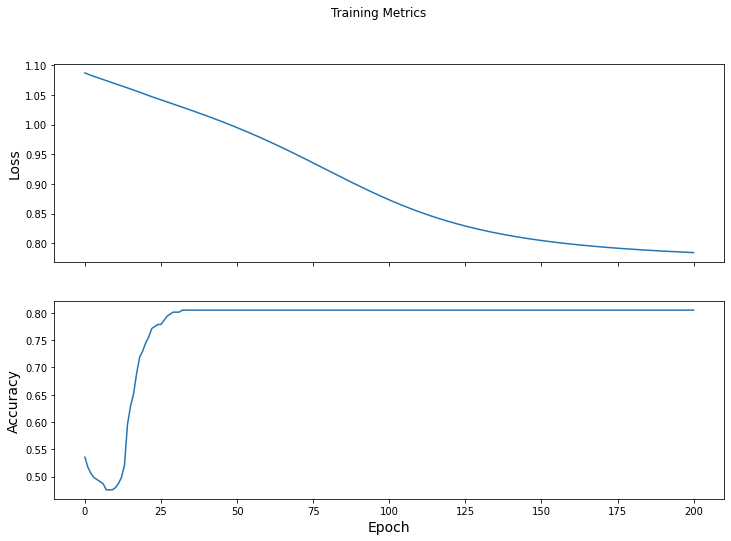

In [ ]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

In [ ]:
# evaluate the model on test set

test_accuracy = tf.keras.metrics.Accuracy()
ds_test_batch = ds_test.batch(10)

for (x, y) in ds_test_batch:
  logits = model(x, training=False)
  prediction = tf.math.argmax(logits, axis=1, output_type=tf.int64)
  test_accuracy(prediction, y)

print(f"test accuracy: {test_accuracy.result(): .3f}")

test accuracy:  0.761


In [ ]:
# make predictions

predict_dataset = tf.convert_to_tensor([
    [0.3, 0.8, 0.4, 0.5,],
    [0.4, 0.1, 0.8, 0.5,],
    [0.7, 0.9, 0.8, 0.4]
])

predictions = model(predict_dataset, training=False)

In [ ]:
for i, logits in enumerate(predictions):
  class_idx = tf.math.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]

  print(f"prediction: {i}, {name}, {p: .3f}")

prediction: 0, Adélie,  0.546
prediction: 1, Gentoo,  0.564
prediction: 2, Adélie,  0.500


In [ ]:
x

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0., 0.],
       [0., 0.]], dtype=float32)>

In [ ]:
y = tf.expand_dims(x, axis=1)

In [ ]:
tf.squeeze(x)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0., 0.],
       [0., 0.]], dtype=float32)>

In [ ]:
y

<tf.Tensor: shape=(2, 1, 2), dtype=float32, numpy=
array([[[0., 0.]],

       [[0., 0.]]], dtype=float32)>

In [ ]:
[[[0., 0.]], [[0., 0.]]]

## Ragged Tensors

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Ragged tensors with Keras

In [ ]:
from transformers import TFAutoModel
import tensorflow as tf

In [ ]:


BERT_MODEL = "bert-base-uncased"

num_tags = 7

encoder = TFAutoModel.from_pretrained(BERT_MODEL)

# tf.keras.layers.Input(shape=[None], dtype=tf.int64, ragged=True)
## NER Model
input_ids = tf.keras.layers.Input(shape=[None], dtype=tf.int32, ragged=True)
attention_mask = tf.keras.layers.Input(shape=[None], dtype=tf.int32)

embedding = encoder(
    input_ids=input_ids,
    attention_mask=attention_mask
)[0]

embedding.trainable = False # Unfreeze BERT layer

embedding = tf.keras.layers.Dropout(0.5)(embedding)
tag_logits = tf.keras.layers.Dense(num_tags+2, activation='softmax')(embedding)

model = keras.Model(
    inputs=[
            input_ids,
            #token_type_ids,
            attention_mask
           ],
    outputs=[tag_logits],
)

optimizer = keras.optimizers.Adam(lr=3e-5)
#optimizer = keras.optimizers.Adam(lr=1e-4)

model.compile(optimizer=optimizer,
              loss=masked_ce_loss,
              metrics=['accuracy'])

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


AttributeError: ignored

## Lazy Loading

https://stackoverflow.com/questions/56086807/lazy-loading-implementation-in-tensorflow

# Custom Loss Function

In [ ]:
# code used for ner tasks

def masked_ce_loss(real, pred):

    mask = tf.math.logical_not(tf.math.equal(real, num_tags+2))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
# for categorical cross entropy

def loss_fcn(target, prediction):
    # Create mask so that the zero padding values are not included in the computation of loss
    padding_mask = tf.math.logical_not(equal(target, 0))
    padding_mask = tf.cast(padding_mask, tf.float32)
    # Compute a sparse categorical cross-entropy loss on the unmasked values
    loss = sparse_categorical_crossentropy(target, prediction, from_logits=True) * padding_mask
    # Compute the mean loss over the unmasked values
    return reduce_sum(loss) / reduce_sum(padding_mask)

# Distributed Training

- distribute the training across multiple machines
- built on data parallelism

# Others